In [8]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import os
import cv2
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
#tf.__version__
from tensorflow.python.client import device_lib

from sklearn import preprocessing

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image


In [9]:

def load_img(img_path,img_shape, preprocess=True):
    
    img_rows=img_shape[0]
    img_cols=img_shape[1]
    #num_channel=img_shape[2]


    img = image.load_img(img_path, target_size=(img_rows, img_cols))    
    if preprocess:
        img = image.img_to_array(img) 
        img = np.expand_dims(img, axis=0)

        img =  preprocess_input(img)
        return img

    #data = np.array(data)
    #data = data.astype('float32')
    #data /= 255
    #labels=np.array(labels)
    #print('data shape',data.shape)
    #print('labels shape',labels.shape)
    return np.array(img)

In [51]:
def lap_mag(channels):
    laps = []
    print(channels.shape)
    for i in range(channels.shape[-1]):
        
        dst = cv2.Laplacian(channels[:,:,i], cv2.CV_32F , 3)
        laps.append(dst)
    mag = np.linalg.norm(laps, axis = 0)
    return mag

In [11]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(None, None, 3))

In [12]:
def get_cnn_out(input, layer_num):
    get_layer_output = K.function([model.input], [l.output for l in model.layers][layer_num])
    layer_out = np.array(get_layer_output(input))
    return layer_out[0]

In [52]:
def local_arg_exrtrema_3(mat1, mat2, mat3):

    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []

    for i in range(1, mat1.shape[0]-1):
        for j in range(1, mat1.shape[1]-1):
            pixel_of_interest = mat2[i,j]
            #if np.abs(pixel_of_interest)>2000:
            #print(pixel_of_interest)
            neighbours = mat2[i-1:i+2, j-1:j+2]
            #neighbours[1,1] = np.NaN  #make center nan
            neighbours_above = mat3[i-1:i+2, j-1:j+2]
            neighbours_below = mat1[i-1:i+2, j-1:j+2]
            
            if (pixel_of_interest >= np.max(neighbours) and pixel_of_interest >= np.max(neighbours_above) and pixel_of_interest >= np.max(neighbours_below)) or (pixel_of_interest <= np.min(neighbours) and pixel_of_interest <= np.min(neighbours_above) and  pixel_of_interest <= np.min(neighbours_below)):
                idx.append(np.array([j,i]))

    return np.unique(idx, axis=0)

def local_arg_exrtrema_1(mat):

    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []

    for i in range(1, mat.shape[0]-1):
        for j in range(1, mat.shape[1]-1):
            pixel_of_interest = mat[i,j]
            neighbours = mat[i-1:i+2, j-1:j+2]
            
            if (pixel_of_interest >= np.max(neighbours)) or (pixel_of_interest <= np.min(neighbours)):
                idx.append(np.array([j,i]))

    return np.unique(idx, axis=0)    

In [53]:

data_path1= './SYS809_projet2021_sequences1/legumesA-02.jpg'  #'./SYS809_projet2021_sequences1/livre1_old.JPG'
data_path2=  './SYS809_projet2021_sequences1/legumesB-02.jpg'

data_path1= './SYS809_projet2021_sequences1/new_livre1.jpg' #'./SYS809_projet2021_sequences1/new_livre1.JPG'
data_path2='./SYS809_projet2021_sequences1/livre2.jpg' # './SYS809_projet2021_sequences1/livre2.JPG'

img = load_img(data_path1, [224,224])

#keypoint_coords = np.array([])

'''# Block 3 : layer 7,8,9
layer_7 = lap_mag(get_cnn_out(img, ))
layer_8 = lap_mag(get_cnn_out(img, 8))
layer_9 = lap_mag(get_cnn_out(img, 9))
#plt.imshow(layer_7),plt.show()
#plt.imshow(layer_8), plt.show()
#plt.imshow(layer_9), plt.show()

keypoint_coords = np.multiply(local_arg_exrtrema_1(layer_7), 4)
keypoint_coords = np.concatenate((keypoint_coords, np.multiply(local_arg_exrtrema_1(layer_8), 4)), axis=0)
keypoint_coords = np.concatenate((keypoint_coords, np.multiply(local_arg_exrtrema_1(layer_9), 4)), axis=0)

# Block 4 : layer 11,12,13
layer_11 = lap_mag(get_cnn_out(img, 11))
layer_12 = lap_mag(get_cnn_out(img, 12))
layer_13 = lap_mag(get_cnn_out(img, 13))
#plt.imshow(layer_13)
#plt.imshow(layer_11),plt.show()
#plt.imshow(layer_12), plt.show()
#plt.imshow(layer_13), plt.show()

keypoint_coords = np.concatenate((keypoint_coords,  np.multiply(local_arg_exrtrema_1(layer_11), 8)), axis=0 )
keypoint_coords = np.concatenate((keypoint_coords,  np.multiply(local_arg_exrtrema_1(layer_12), 8)), axis=0 )
keypoint_coords = np.concatenate((keypoint_coords,  np.multiply(local_arg_exrtrema_1(layer_13), 8)), axis=0 )


# Block 4 : layer 15,16,17
layer_15 = lap_mag(get_cnn_out(img, 15))
layer_16 = lap_mag(get_cnn_out(img, 16))
layer_17 = lap_mag(get_cnn_out(img, 17))
keypoint_coords = np.concatenate((keypoint_coords, np.multiply( local_arg_exrtrema_1(layer_15), 16)), axis=0  )
keypoint_coords = np.concatenate((keypoint_coords, np.multiply( local_arg_exrtrema_1(layer_16), 16)), axis=0  )
keypoint_coords = np.concatenate((keypoint_coords, np.multiply( local_arg_exrtrema_1(layer_17), 16)), axis=0  )
'''
layer_3 = lap_mag(get_cnn_out(img, 3))
layer_6 = lap_mag(get_cnn_out(img, 6))
layer_10 = lap_mag(get_cnn_out(img, 10))
layer_14 = lap_mag(get_cnn_out(img, 14))
#plt.imshow(layer_7),plt.show()
#plt.imshow(layer_8), plt.show()
#plt.imshow(layer_9), plt.show()


keypoint_coords = np.multiply(local_arg_exrtrema_1(layer_6), 4)
#keypoint_coords = np.concatenate((keypoint_coords, np.multiply(local_arg_exrtrema_1(layer_6), 4)), axis=0)
keypoint_coords = np.concatenate((keypoint_coords, np.multiply(local_arg_exrtrema_1(layer_10), 8)), axis=0)
keypoint_coords = np.concatenate((keypoint_coords, np.multiply(local_arg_exrtrema_1(layer_14), 16)), axis=0)



(112, 112, 64)
(56, 56, 128)
(28, 28, 256)
(14, 14, 512)


In [54]:
keypoint_coords

array([[  4,  36],
       [  4,  64],
       [  4,  88],
       [  4, 100],
       [  4, 120],
       [  8,  44],
       [  8,  56],
       [  8,  64],
       [  8,  84],
       [  8, 112],
       [  8, 132],
       [  8, 184],
       [ 12,  16],
       [ 12,  32],
       [ 12,  68],
       [ 12,  88],
       [ 12, 108],
       [ 12, 116],
       [ 12, 136],
       [ 12, 172],
       [ 12, 212],
       [ 16,   8],
       [ 16,  24],
       [ 16,  60],
       [ 16,  76],
       [ 16, 124],
       [ 16, 180],
       [ 20,  40],
       [ 20,  88],
       [ 20, 112],
       [ 20, 152],
       [ 20, 176],
       [ 20, 192],
       [ 24,  48],
       [ 24,  56],
       [ 24,  84],
       [ 24,  92],
       [ 24, 108],
       [ 24, 116],
       [ 24, 128],
       [ 24, 188],
       [ 24, 204],
       [ 28,  28],
       [ 28,  64],
       [ 28,  72],
       [ 28, 176],
       [ 32,   8],
       [ 32,  20],
       [ 32, 132],
       [ 36,  44],
       [ 36,  56],
       [ 36,  84],
       [ 36,

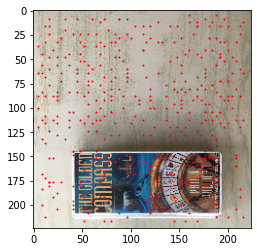

In [55]:
img = load_img(data_path1,[224,224], preprocess=False)

k=[]
for row, col in keypoint_coords:
    #print(float(row), float(col))
    keypoint = cv2.KeyPoint()
    keypoint.pt = (float(row), float(col))
    keypoint.octave = 0
    keypoint.size = 0
    keypoint.response = 0
    k.append(keypoint)

img1_pts = np.float32([ kp.pt for kp in k])

plt.figure()
plt.imshow(img)
plt.scatter(list(list(zip(*img1_pts))[0]), list(list(zip(*img1_pts))[1]), s=[1], c='r')


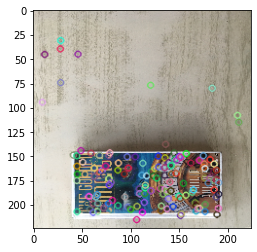

In [33]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img,None)

#Le champ .pt des object KeyPoint contiennent la position du point-cle

plt.imshow(cv2.drawKeypoints(img,kp1,None))

In [34]:
kp1

(<KeyPoint 000001825AB74570>,
 <KeyPoint 000001825FB904B0>,
 <KeyPoint 000001826EB8DAB0>,
 <KeyPoint 000001825B6154B0>,
 <KeyPoint 000001826EB1B600>,
 <KeyPoint 000001826F0145D0>,
 <KeyPoint 000001826F01BDE0>,
 <KeyPoint 000001826EB7F840>,
 <KeyPoint 000001825B9A7480>,
 <KeyPoint 000001826EFFF8D0>,
 <KeyPoint 000001826EFFF9C0>,
 <KeyPoint 000001826F060B10>,
 <KeyPoint 000001826EB48C60>,
 <KeyPoint 000001826EB48AE0>,
 <KeyPoint 000001825B9DB3C0>,
 <KeyPoint 000001825B9DB0C0>,
 <KeyPoint 000001825B9DB270>,
 <KeyPoint 000001825B9CC720>,
 <KeyPoint 000001825FAF3060>,
 <KeyPoint 000001825FB1A810>,
 <KeyPoint 000001825FB1A4B0>,
 <KeyPoint 000001825FB1A030>,
 <KeyPoint 000001825FB1A420>,
 <KeyPoint 000001825FB1A120>,
 <KeyPoint 000001826F09B750>,
 <KeyPoint 000001826F09BA20>,
 <KeyPoint 000001826F09B660>,
 <KeyPoint 000001826F09B870>,
 <KeyPoint 000001826F09B630>,
 <KeyPoint 000001826F09B600>,
 <KeyPoint 000001826F09BBA0>,
 <KeyPoint 000001826F09B720>,
 <KeyPoint 000001826F09BA50>,
 <KeyPoint